In [1]:
import numpy as np
import numpy.fft as fft
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
from collections import defaultdict
from numpy import hamming
import os
import pickle

In [2]:
PATH = '../WESAD/'
SUBJECTS = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '16', '17']
CHEST_SIGNALS = ['ECG', 'EMG', 'EDA', 'Resp', 'Temp', 'ACC']
CHEST_SAMPLING_RATE = 700

In [3]:
def read_subject_data(subject) :
    path = PATH + 'S' + subject + '/S' + subject + '.pkl'
    subject = pd.read_pickle(path)
    
    return subject

In [4]:
def visualize_raw(signal, duration, sampling_rate, title) :
    n = duration * sampling_rate
    l = len(signal)
    
    s = random.randint(0, l - n)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = np.arange(n)
    df['y'] = signal[s:s+n]
    
    plt.figure(figsize=(20, 5))
    sns.scatterplot(x = 'x', y = 'y', data = df, s = 3).set(title=title)

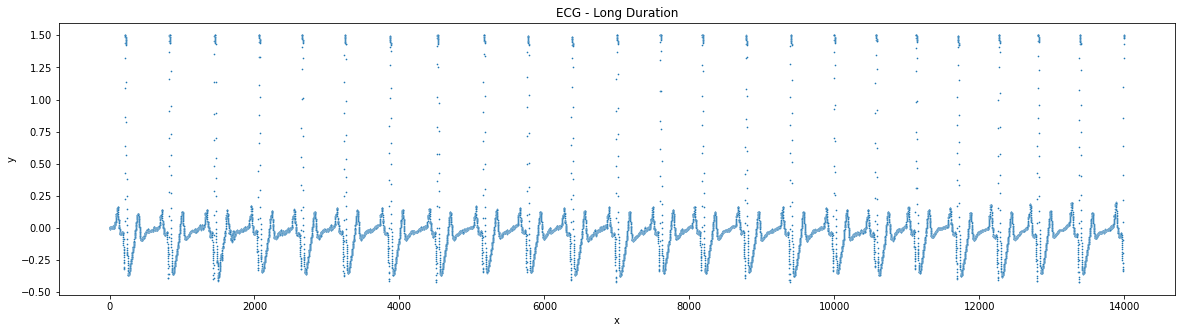

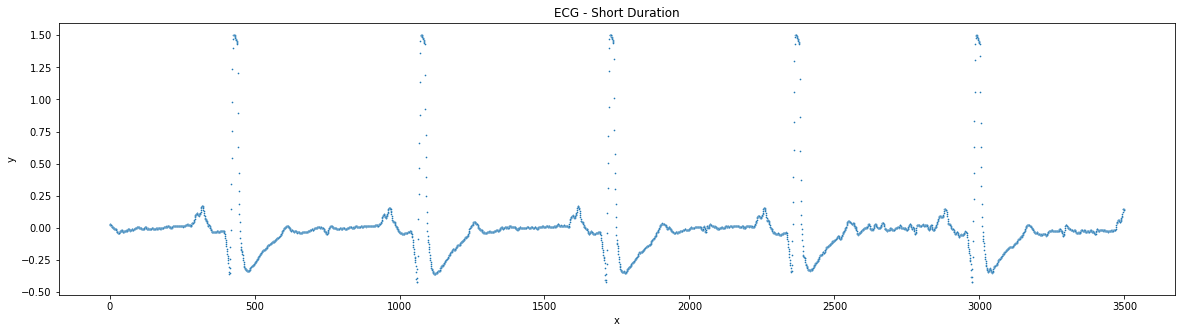

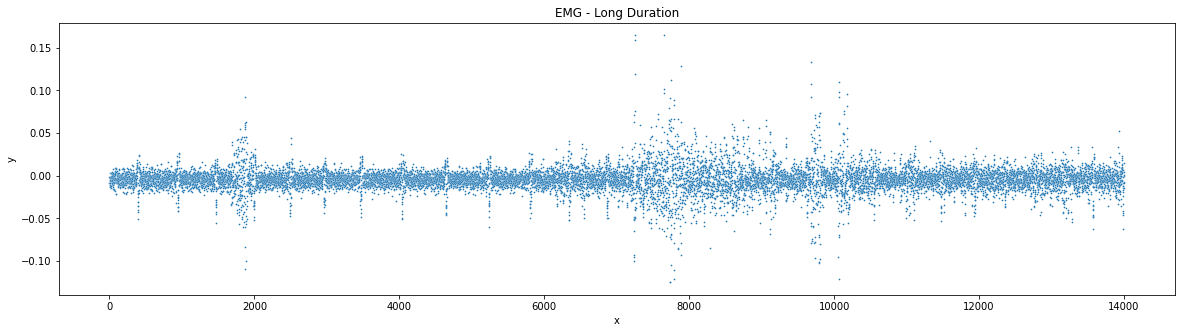

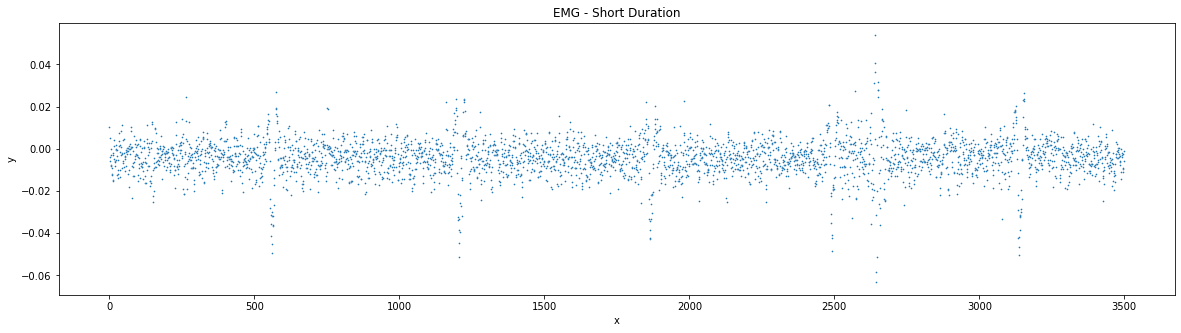

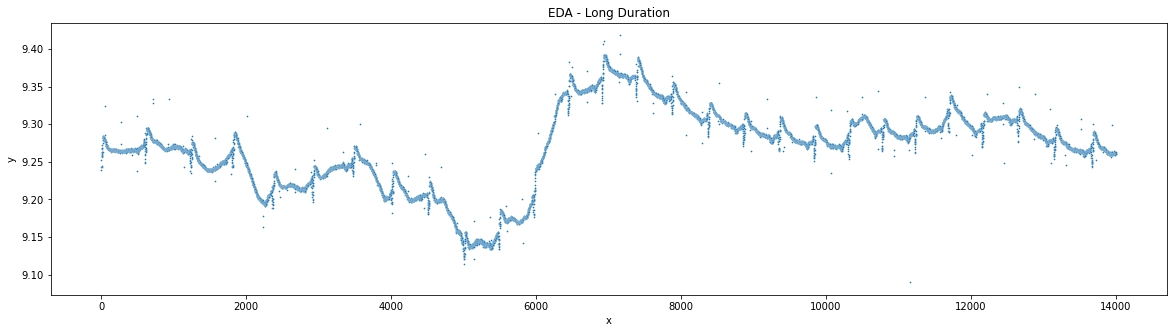

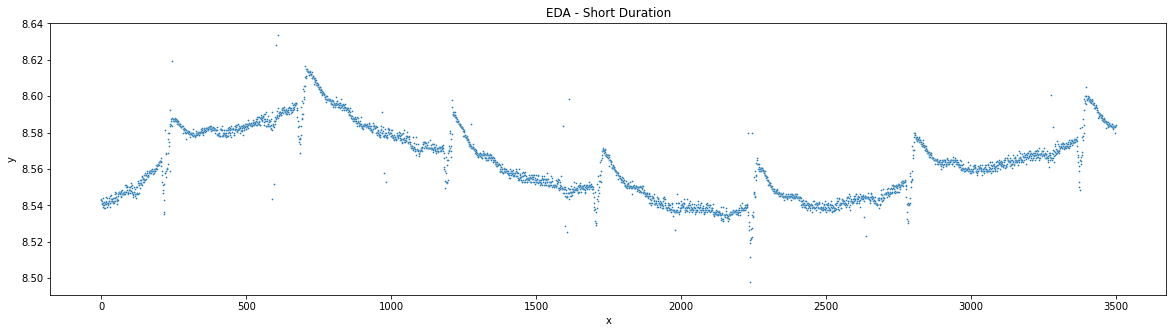

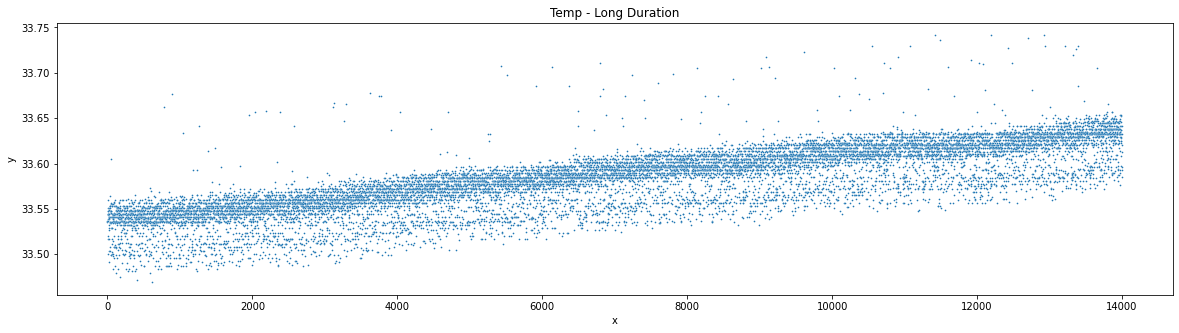

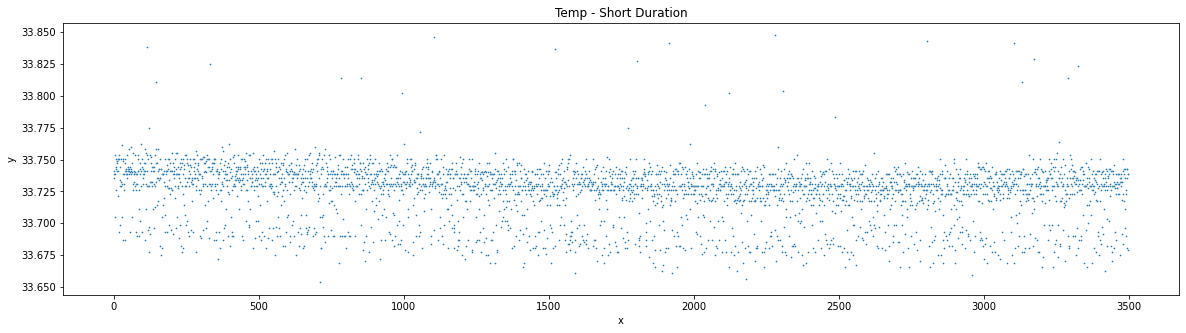

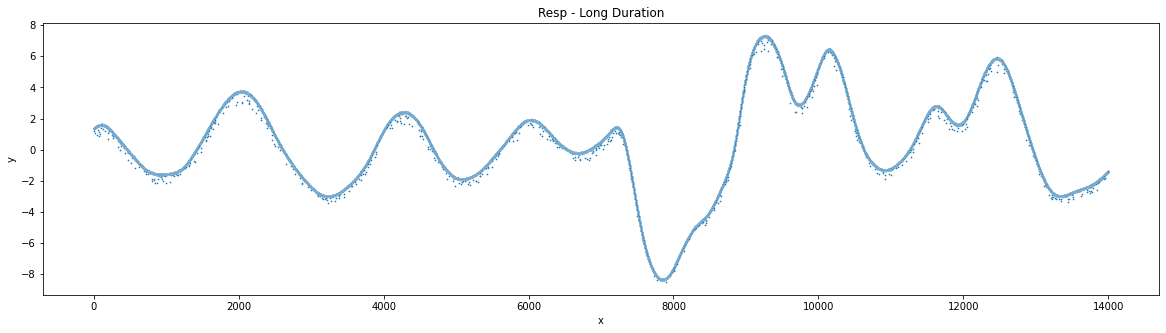

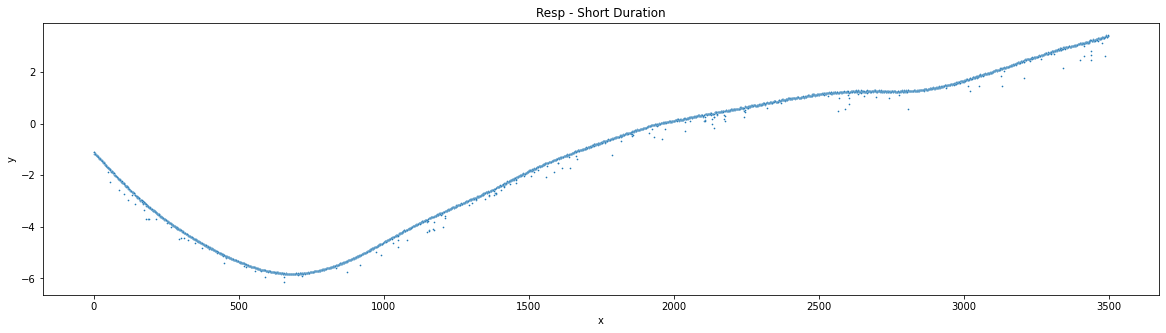

In [5]:
# Visualize the different chest signals for a random subject

SAMPLING_RATE = 700
LONG_DURATION = 20
SHORT_DURATION = 5

subject = random.choice(SUBJECTS)
subject_data = read_subject_data(subject)

chest_signals = subject_data['signal']['chest']

for signal_type in chest_signals :
    if signal_type == 'ACC' :
        continue
    
    signal = chest_signals[signal_type]
    visualize_raw(signal, LONG_DURATION, SAMPLING_RATE, signal_type + ' - Long Duration')
    visualize_raw(signal, SHORT_DURATION, SAMPLING_RATE, signal_type + ' - Short Duration')

In [6]:
# Get additional notes for the Subjects

for subject in SUBJECTS :
    with open(PATH + 'S' + subject + '/S' + subject + '_readme.txt', 'r') as file :
        print(subject, file.readlines()[16])

2 The RespiBAN temperature sensor was not fully attached throughout the entire duration of the study protocol.

3 During the baseline condition, the subject was sitting in a sunny workplace.

4 -

5 Subject might have fallen asleep during the first meditation.

6 Subject claimed that he had a stressfull week and hence the study was rather relaxing for him.

7 -

8 Subject had already a rather stressful day, prior to the study.

9 -

10 -

11 -

13 -

14 -

15 Subject didn't really believe the cover story of the stress condition (TSST).

16 Subject felt rather cold in the room where the stress condition was carried out.

17 The RespiBAN temperature sensor was not fully attached throughout the entire duration of the study protocol.



In [7]:
# https://imotions.com/blog/eda/
# https://www.scitepress.org/Papers/2021/102446/102446.pdf
# https://sci-hub.ee/10.1016/j.cmpb.2020.105482
WINDOW_LEN = 20
OVERLAP = 0.75
NUM_FEATURES = 10

In [8]:
# Identify the continuous intervals for each label
def find_intervals(labels) :
    intervals = []

    l = len(labels)
    i = 0
    label = labels[0]

    for j in range(l):
        if label != labels[j]:
            intervals.append({
                'label' : label, 
                'beg' : i,
                'end' : j
                })
            i = j
            label = labels[j]

    intervals.append({
        'label' : label, 
        'beg' : i,
        'end' : l
    })

    return intervals    

In [9]:
def extract_fft_features(signal, num_features) :
    window = hamming(len(signal))
    signal *= window
    coeffs = fft.fft(signal)
    l = len(coeffs)
    freqs = fft.fftfreq(l)
    
    # Discard the negative elems
    l //= 2
    amps = np.abs(coeffs[0:l])
    freqs = np.abs(freqs[0:l])
    
    # Sort descending w.r.t amp   
    p = amps.argsort()[::-1]
    freqs = freqs[p]
    amps = amps[p]
    
    features = [[amps[i], freqs[i]] for i in range(num_features)]   
    return np.array(features)

In [10]:
def normalize_fft_features(train_features, test_features) :
    feature_mean = np.mean(train_features, axis=0)
    print(np.shape(feature_mean))
    feature_std = np.std(train_features, axis=0)
    train_features -= feature_mean
    test_features -= feature_mean
    train_features = np.divide(train_features, feature_std, out=np.zeros_like(train_features), where=feature_std!=0)
    test_features = np.divide(test_features, feature_std, out=np.zeros_like(test_features), where=feature_std!=0)
    
    return train_features, test_features

In [11]:
TRANSIENT = 0
BASELINE = 1
STRESS = 2
AMUSEMENT = 3
MEDITATION = 4
IGNORE = 5

def extract_signal_features(signal, intervals, sampling_rate, window_len = WINDOW_LEN, overlap = OVERLAP, num_features = NUM_FEATURES) :
    segment_size = sampling_rate * window_len
    signal_features = {
        BASELINE : [],
        STRESS : [],
        AMUSEMENT : [],
        MEDITATION : []
    }
    
    baseline_av = 0
    
    for interval in intervals :
        label = interval['label']
        beg = interval['beg']
        end = interval['end']
        
        signal_of_interest = signal[beg:end]  
        
        if label >= IGNORE or label == TRANSIENT:
            baseline_av = (np.mean(signal_of_interest) + baseline_av)/2
            continue      
            
        if label == BASELINE :
            baseline_av = (np.mean(signal_of_interest) + baseline_av)/2
        
        signal_of_interest -= baseline_av
        
        l = end - beg        
        while l >= segment_size:
            segment = signal_of_interest[int(l - segment_size) : l]
            l -= int((1 - overlap) * segment_size)
            
            segment_features = extract_fft_features(segment, num_features)            
            signal_features[label].append(segment_features)
        
    return signal_features

In [12]:
# Get Joint test-train  Datasets combining all signals

def get_chest_signal_dataset(subjects, signal_types = CHEST_SIGNALS) :
    combined_subject_features = {}
    
    for subject in subjects :
        subject_data = read_subject_data(subject)
        intervals = find_intervals(subject_data['label'])
        
        subject_features = {
            BASELINE : [],
            STRESS : [],
            AMUSEMENT : [],
            MEDITATION : []
        }
        
        for signal_type in signal_types :
            if signal_type == 'ACC' :
                continue
                
            signal = np.array(subject_data['signal']['chest'][signal_type]).flatten()
            signal_features = extract_signal_features(signal, intervals, CHEST_SAMPLING_RATE)
            
            for label, features in signal_features.items() :
                subject_features[label].append(features)
                
        for label in subject_features :
            subject_features[label] = np.stack(subject_features[label], axis = -1)
            
        aggregate_subject_features = []
        aggregate_subject_labels = []
            
        for label, features in subject_features.items() :
            for feature in features :
                aggregate_subject_features.append(feature)
                aggregate_subject_labels.append(label)
                
        feature_mean = np.mean(aggregate_subject_features, axis=0)
        feature_std = np.std(aggregate_subject_features, axis=0)
        
        aggregate_subject_features = np.array(aggregate_subject_features) - feature_mean
        aggregate_subject_features = np.divide(aggregate_subject_features, feature_std, out=np.zeros_like(aggregate_subject_features), where=feature_std!=0)
                
        combined_subject_features[subject] = {
            'features' : aggregate_subject_features,
            'labels' : aggregate_subject_labels
        }

    return combined_subject_features

In [13]:
def generate_dataset(combined_subject_features, subjects) :
    features_dataset = []
    labels_dataset = []
    
    for subject in subjects :
        features_dataset += list(combined_subject_features[subject]['features'])
        labels_dataset += combined_subject_features[subject]['labels']
        
    return np.array(features_dataset), np.array(labels_dataset)

In [14]:
def encode_labels(labels) :
    encoder = {
        1 : [1, 0, 0, 0],
        2 : [0, 1, 0, 0],
        3 : [0, 0, 1, 0],
        4 : [0, 0, 0, 1]
    }
    
    return np.array([np.array(encoder[l]) for l in labels])

In [15]:
combined_subject_features = get_chest_signal_dataset(SUBJECTS)

In [16]:
train_features, train_labels = generate_dataset(combined_subject_features, ['2', '15', '16', '3', '4', '5', '6', '7', '11', '13', '14', '10', '17', '9'])
test_features, test_labels = generate_dataset(combined_subject_features, ['8'])

In [17]:
train_labels = encode_labels(train_labels)
test_labels = encode_labels(test_labels)

In [25]:
checkpoint_filepath = '../Models/Tmp.hdf5'

In [18]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(10, 2, 5)),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish', depth_multiplier=2),
    keras.layers.BatchNormalization(axis=1),
    keras.layers.Conv2D(4, kernel_size=(1, 1), activation='swish'),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish', depth_multiplier=2),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(4, kernel_size=(3,1), activation='swish'),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish'),
    keras.layers.Conv2D(6, kernel_size=(1,2), activation='swish'),
    keras.layers.Conv2D(6, kernel_size=(2,1), activation='swish'),
    keras.layers.Flatten(),
    keras.layers.Dense(units=6,  activation='swish'),
    keras.layers.Dense(units=6,  activation='swish'),
    keras.layers.Dense(units=4, activation='softmax')
])

In [19]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(10, 2, 5)),
    keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish', depth_multiplier=2),
    keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish'),
    keras.layers.Conv2D(4, kernel_size=(1, 1), activation='swish'),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish', depth_multiplier=2),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(4, kernel_size=(3,1), activation='swish'),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish'),
    keras.layers.BatchNormalization(axis=1),
    keras.layers.Conv2D(5, kernel_size=(1,2), activation='swish'),
    keras.layers.Conv2D(5, kernel_size=(2,1), activation='swish'),
    keras.layers.Flatten(),
    keras.layers.Dense(units=5,  activation='swish'),
    keras.layers.Dense(units=4, activation='softmax')
])

In [20]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(10, 2, 5)),
    keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish', depth_multiplier=2),
    keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish'),
    keras.layers.SpatialDropout2D(0.5),
    keras.layers.Conv2D(6, kernel_size=(1, 1), activation='swish'),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish'),
    keras.layers.Conv2D(6, kernel_size=(3,1), activation='swish'),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish'),
    keras.layers.Conv2D(8, kernel_size=(1,2), activation='swish'),
    keras.layers.Conv2D(8, kernel_size=(2,1), activation='swish'),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
#     keras.layers.Dense(units=12,  activation='swish'),
    keras.layers.Dense(units=8,  activation='swish'),
    keras.layers.Dense(units=4, activation='softmax')
])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
depthwise_conv2d_7 (Depthwis (None, 9, 2, 10)          30        
_________________________________________________________________
depthwise_conv2d_8 (Depthwis (None, 8, 2, 10)          30        
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 8, 2, 10)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 2, 6)           66        
_________________________________________________________________
depthwise_conv2d_9 (Depthwis (None, 6, 2, 6)           24        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 2, 6)           114       
_________________________________________________________________
depthwise_conv2d_10 (Depthwi (None, 2, 2, 6)          

In [22]:
model.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [23]:
print(np.shape(train_features), np.shape(train_labels), np.shape(test_features), np.shape(test_labels))

(8158, 10, 2, 5) (8158, 4) (584, 10, 2, 5) (584, 4)


In [26]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [27]:
model.fit(train_features, train_labels, epochs=800, batch_size = 16, verbose=1, shuffle=True,
                  validation_data=(test_features,  test_labels), callbacks=[model_checkpoint_callback])

Epoch 1/800
510/510 [==============================] - 2s 2ms/step - loss: 1.0221 - accuracy: 0.5601 - val_loss: 0.5548 - val_accuracy: 0.8579

Epoch 00001: val_loss improved from inf to 0.55481, saving model to ../Models/Tmp.hdf5
Epoch 2/800
510/510 [==============================] - 1s 1ms/step - loss: 0.6805 - accuracy: 0.7175 - val_loss: 0.4601 - val_accuracy: 0.8322

Epoch 00002: val_loss improved from 0.55481 to 0.46012, saving model to ../Models/Tmp.hdf5
Epoch 3/800
510/510 [==============================] - 1s 1ms/step - loss: 0.6488 - accuracy: 0.7350 - val_loss: 0.5929 - val_accuracy: 0.7209

Epoch 00003: val_loss did not improve from 0.46012
Epoch 4/800
510/510 [==============================] - 1s 1ms/step - loss: 0.6228 - accuracy: 0.7524 - val_loss: 0.4099 - val_accuracy: 0.9298

Epoch 00004: val_loss improved from 0.46012 to 0.40992, saving model to ../Models/Tmp.hdf5
Epoch 5/800
510/510 [==============================] - 1s 1ms/step - loss: 0.5926 - accuracy: 0.7651 - v

510/510 [==============================] - 1s 1ms/step - loss: 0.3973 - accuracy: 0.8433 - val_loss: 0.2667 - val_accuracy: 0.9041

Epoch 00040: val_loss did not improve from 0.19962
Epoch 41/800
510/510 [==============================] - 1s 1ms/step - loss: 0.4073 - accuracy: 0.8353 - val_loss: 0.2214 - val_accuracy: 0.9161

Epoch 00041: val_loss did not improve from 0.19962
Epoch 42/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3949 - accuracy: 0.8446 - val_loss: 0.2327 - val_accuracy: 0.9075

Epoch 00042: val_loss did not improve from 0.19962
Epoch 43/800
510/510 [==============================] - 1s 1ms/step - loss: 0.4050 - accuracy: 0.8373 - val_loss: 0.2509 - val_accuracy: 0.9024

Epoch 00043: val_loss did not improve from 0.19962
Epoch 44/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3973 - accuracy: 0.8436 - val_loss: 0.2410 - val_accuracy: 0.9247

Epoch 00044: val_loss did not improve from 0.19962
Epoch 45/800
510/510 [===========

510/510 [==============================] - 1s 1ms/step - loss: 0.3790 - accuracy: 0.8572 - val_loss: 0.1902 - val_accuracy: 0.9281

Epoch 00081: val_loss did not improve from 0.18058
Epoch 82/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3794 - accuracy: 0.8513 - val_loss: 0.2398 - val_accuracy: 0.9092

Epoch 00082: val_loss did not improve from 0.18058
Epoch 83/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3621 - accuracy: 0.8594 - val_loss: 0.2078 - val_accuracy: 0.9024

Epoch 00083: val_loss did not improve from 0.18058
Epoch 84/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3590 - accuracy: 0.8566 - val_loss: 0.2208 - val_accuracy: 0.9178

Epoch 00084: val_loss did not improve from 0.18058
Epoch 85/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3699 - accuracy: 0.8500 - val_loss: 0.2425 - val_accuracy: 0.9212

Epoch 00085: val_loss did not improve from 0.18058
Epoch 86/800
510/510 [===========

510/510 [==============================] - 1s 1ms/step - loss: 0.3419 - accuracy: 0.8670 - val_loss: 0.1758 - val_accuracy: 0.9281

Epoch 00122: val_loss did not improve from 0.14984
Epoch 123/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3381 - accuracy: 0.8684 - val_loss: 0.2192 - val_accuracy: 0.9178

Epoch 00123: val_loss did not improve from 0.14984
Epoch 124/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3417 - accuracy: 0.8644 - val_loss: 0.2446 - val_accuracy: 0.9041

Epoch 00124: val_loss did not improve from 0.14984
Epoch 125/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3401 - accuracy: 0.8652 - val_loss: 0.1668 - val_accuracy: 0.9452

Epoch 00125: val_loss did not improve from 0.14984
Epoch 126/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3444 - accuracy: 0.8660 - val_loss: 0.1453 - val_accuracy: 0.9486

Epoch 00126: val_loss improved from 0.14984 to 0.14526, saving model to ../Model

Epoch 163/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3142 - accuracy: 0.8737 - val_loss: 0.1265 - val_accuracy: 0.9538

Epoch 00163: val_loss did not improve from 0.12116
Epoch 164/800
510/510 [==============================] - 1s 2ms/step - loss: 0.3265 - accuracy: 0.8674 - val_loss: 0.1521 - val_accuracy: 0.9298

Epoch 00164: val_loss did not improve from 0.12116
Epoch 165/800
510/510 [==============================] - 1s 2ms/step - loss: 0.3191 - accuracy: 0.8753 - val_loss: 0.1185 - val_accuracy: 0.9555

Epoch 00165: val_loss improved from 0.12116 to 0.11846, saving model to ../Models/Tmp.hdf5
Epoch 166/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3243 - accuracy: 0.8723 - val_loss: 0.1739 - val_accuracy: 0.9281

Epoch 00166: val_loss did not improve from 0.11846
Epoch 167/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3259 - accuracy: 0.8713 - val_loss: 0.1840 - val_accuracy: 0.9281

Epoch 00167: val_loss did 


Epoch 00203: val_loss did not improve from 0.10557
Epoch 204/800
510/510 [==============================] - 1s 2ms/step - loss: 0.3185 - accuracy: 0.8775 - val_loss: 0.2316 - val_accuracy: 0.9092

Epoch 00204: val_loss did not improve from 0.10557
Epoch 205/800
510/510 [==============================] - 1s 2ms/step - loss: 0.3287 - accuracy: 0.8726 - val_loss: 0.1443 - val_accuracy: 0.9469

Epoch 00205: val_loss did not improve from 0.10557
Epoch 206/800
510/510 [==============================] - 1s 2ms/step - loss: 0.3213 - accuracy: 0.8778 - val_loss: 0.1336 - val_accuracy: 0.9555

Epoch 00206: val_loss did not improve from 0.10557
Epoch 207/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3130 - accuracy: 0.8768 - val_loss: 0.1292 - val_accuracy: 0.9555

Epoch 00207: val_loss did not improve from 0.10557
Epoch 208/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3144 - accuracy: 0.8779 - val_loss: 0.1470 - val_accuracy: 0.9435

Epoch 00208: v

510/510 [==============================] - 1s 2ms/step - loss: 0.3179 - accuracy: 0.8741 - val_loss: 0.1672 - val_accuracy: 0.9298

Epoch 00245: val_loss did not improve from 0.09919
Epoch 246/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3108 - accuracy: 0.8802 - val_loss: 0.1318 - val_accuracy: 0.9503

Epoch 00246: val_loss did not improve from 0.09919
Epoch 247/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3084 - accuracy: 0.8779 - val_loss: 0.1161 - val_accuracy: 0.9521

Epoch 00247: val_loss did not improve from 0.09919
Epoch 248/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3045 - accuracy: 0.8847 - val_loss: 0.1292 - val_accuracy: 0.9521

Epoch 00248: val_loss did not improve from 0.09919
Epoch 249/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3153 - accuracy: 0.8761 - val_loss: 0.1823 - val_accuracy: 0.9144

Epoch 00249: val_loss did not improve from 0.09919
Epoch 250/800
510/510 [======

510/510 [==============================] - 1s 1ms/step - loss: 0.3077 - accuracy: 0.8786 - val_loss: 0.1274 - val_accuracy: 0.9503

Epoch 00286: val_loss did not improve from 0.09814
Epoch 287/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3033 - accuracy: 0.8807 - val_loss: 0.1586 - val_accuracy: 0.9264

Epoch 00287: val_loss did not improve from 0.09814
Epoch 288/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3015 - accuracy: 0.8796 - val_loss: 0.1164 - val_accuracy: 0.9572

Epoch 00288: val_loss did not improve from 0.09814
Epoch 289/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3070 - accuracy: 0.8802 - val_loss: 0.1762 - val_accuracy: 0.9401

Epoch 00289: val_loss did not improve from 0.09814
Epoch 290/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3084 - accuracy: 0.8810 - val_loss: 0.1319 - val_accuracy: 0.9503

Epoch 00290: val_loss did not improve from 0.09814
Epoch 291/800
510/510 [======

510/510 [==============================] - 1s 1ms/step - loss: 0.3005 - accuracy: 0.8789 - val_loss: 0.1342 - val_accuracy: 0.9503

Epoch 00327: val_loss did not improve from 0.09369
Epoch 328/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3073 - accuracy: 0.8793 - val_loss: 0.1633 - val_accuracy: 0.9384

Epoch 00328: val_loss did not improve from 0.09369
Epoch 329/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3103 - accuracy: 0.8740 - val_loss: 0.1183 - val_accuracy: 0.9589

Epoch 00329: val_loss did not improve from 0.09369
Epoch 330/800
510/510 [==============================] - 1s 1ms/step - loss: 0.2965 - accuracy: 0.8876 - val_loss: 0.1596 - val_accuracy: 0.9349

Epoch 00330: val_loss did not improve from 0.09369
Epoch 331/800
510/510 [==============================] - 1s 1ms/step - loss: 0.3096 - accuracy: 0.8790 - val_loss: 0.1577 - val_accuracy: 0.9332

Epoch 00331: val_loss did not improve from 0.09369
Epoch 332/800
510/510 [======

KeyboardInterrupt: 

In [ ]:
model.load_weights(checkpoint_filepath)

<AxesSubplot:>

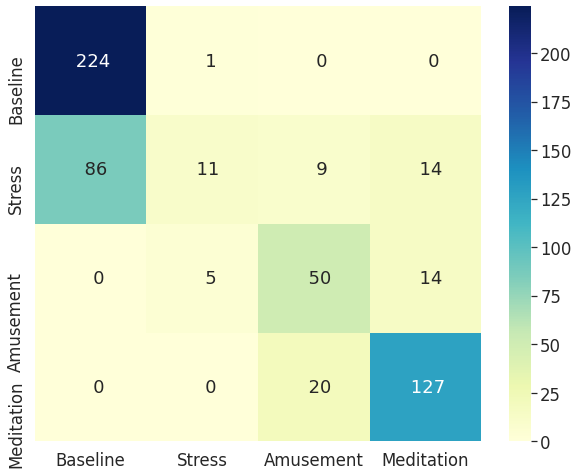

In [443]:
predicted_labels = model.predict(test_features)

confusion_matrix = np.zeros((4, 4))

for test_label, predicted_label in zip(test_labels, predicted_labels) :
    i = np.argmax(test_label)
    j = np.argmax(predicted_label)
    
    confusion_matrix[i][j] += 1

    
classes = ['Baseline', 'Stress', 'Amusement', 'Meditation']
df = pd.DataFrame(confusion_matrix, classes, classes)

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, fmt="4.0f", cmap="YlGnBu")

In [876]:
model.evaluate(test_features, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 0.7208 - accuracy: 0.6952


[0.7208217978477478, 0.6951871514320374]

In [1185]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=64,
    restore_best_weights=True,
    verbose=1
)

In [233]:
model_checkpoint_callback.

SyntaxError: invalid syntax (<ipython-input-233-84f5a96af3a0>, line 1)

In [239]:
data = tf.constant(np.arange(10).reshape(5, 2) * 10, dtype=tf.float32)

In [240]:
print(data)

tf.Tensor(
[[ 0. 10.]
 [20. 30.]
 [40. 50.]
 [60. 70.]
 [80. 90.]], shape=(5, 2), dtype=float32)


In [247]:
layer = tf.keras.layers.LayerNormalization(axis=0, scale=False)

In [248]:
output = layer(data)

In [249]:
print(output)

tf.Tensor(
[[-1.4142127  -1.4142127 ]
 [-0.70710635 -0.70710635]
 [ 0.          0.        ]
 [ 0.70710635  0.7071065 ]
 [ 1.4142127   1.4142128 ]], shape=(5, 2), dtype=float32)


In [798]:
a = np.divide(a, np.sum(a, axis=1))

In [794]:
a = [[1, 1], [2, 3]]

In [81]:
model.

TypeError: gradients_v2() missing 2 required positional arguments: 'ys' and 'xs'

In [1220]:
model.loss()

Object `model.loss()` not found.


In [1572]:
l = model.get_layer('spatial_dropout2d_341')

In [1573]:
l.rate = 0.2